In [1]:
import os
import sys
import yaml

import numpy as np
import matplotlib.pyplot as plt

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.insert(0, project_root)

from scipy.stats import spearmanr


In [31]:
target_dir = "./B/target/intermediates/"
shadow_dir = "./B/output/intermediates/"

#no_shadows = 64
#no_samples = 99

#random_target = False

scores = {}


In [4]:
from sampling import load_results

target_logits, target_inmask = load_results(target_dir+"/lira", signal_name="rescaled_logits.npy")
shadow_logits, shadow_inmask = load_results(shadow_dir+"/lira", signal_name="rescaled_logits.npy")
target_probs, _ = load_results(target_dir+"/rmia", signal_name="gtl_probabilities.npy")
assert (_==target_inmask).all()
shadow_probs, _ = load_results(shadow_dir+"/rmia", signal_name="gtl_probabilities.npy")
assert (_==shadow_inmask).all()
print(target_logits.shape, target_probs.shape, target_inmask.shape)
print(shadow_logits.shape, shadow_probs.shape, shadow_inmask.shape)


NOTE: all masks are unique as expected: 1 total
NOTE: all masks are unique as expected: 64 total
NOTE: all masks are unique as expected: 1 total
NOTE: all masks are unique as expected: 64 total
(60000, 1) (60000, 1) (60000, 1)
(60000, 64) (60000, 64) (60000, 64)


In [32]:
%%time

from leakpro.attacks.mia_attacks.lira import lira_vectorized

scores["lira"] = lira_vectorized(target_logits.ravel(), shadow_logits, shadow_inmask, var_calculation = "individual_carlini")


CPU times: user 521 ms, sys: 72.5 ms, total: 593 ms
Wall time: 590 ms


In [33]:
%%time

from leakpro.attacks.mia_attacks.rmia import rmia_vectorised

scores["rmia"] = rmia_vectorised(target_probs.ravel(), shadow_probs, shadow_inmask)


CPU times: user 152 ms, sys: 27.6 ms, total: 179 ms
Wall time: 176 ms


In [37]:
from sklearn.metrics import roc_curve

curves = { 
    key: roc_curve(target_inmask[~np.isnan(scores[key]),0], scores[key][~np.isnan(scores[key])]) for key in scores.keys()
}


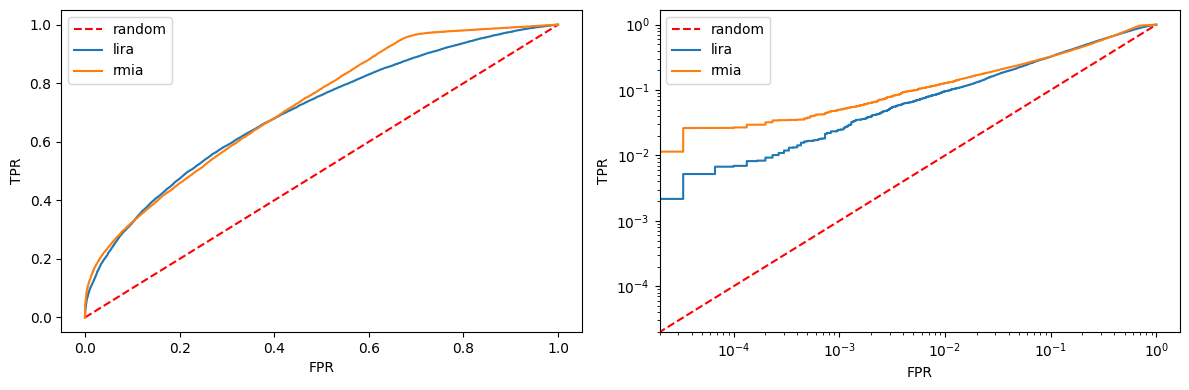

In [38]:
fpr0 = curves["lira"][0]

fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(fpr0, fpr0, 'r--', label="random")
axs[1].loglog(fpr0, fpr0, 'r--', label="random")
for i in [0,1]:
    for (key,(fpr, tpr, _)) in curves.items():
        axs[i].plot(fpr, tpr, label=key)
    axs[i].set_xlabel("FPR")
    axs[i].set_ylabel("TPR")
    axs[i].legend()
plt.tight_layout()
plt.show()


In [44]:
thresholds = { 
    key: l[np.where(fpr >= 0.01)[0][0]].item() for (key, (fpr, tpr, l)) in curves.items() 
}    
thresholds


{'lira': -0.00455437938344696, 'rmia': 0.9313833713531494}

In [45]:
tp = {
    key: (scores[key] > thresholds[key]) & target_inmask.ravel() for key in scores.keys()
}


{'lira': array([ True, False, False, ..., False, False, False], shape=(60000,)),
 'rmia': array([False, False, False, ..., False, False, False], shape=(60000,))}

In [50]:
print("TPR for each set", [tp[key].sum()/sum(target_inmask) for key in curves.keys()])
print("Intersection", np.sum(tp["lira"] & tp["rmia"])/sum(target_inmask))
print("Union", np.sum(tp["lira"] | tp["rmia"])/sum(target_inmask))


TPR for each set [array([0.096]), array([0.12723333])]
Intersection [0.07106667]
Union [0.15216667]


In [56]:
rho, p_value = spearmanr(scores["lira"], scores["rmia"])

print(f"Spearman's rank correlation (rho): {rho}")
print(f"P-value: {p_value}")


Spearman's rank correlation (rho): 0.7236038711684729
P-value: 0.0


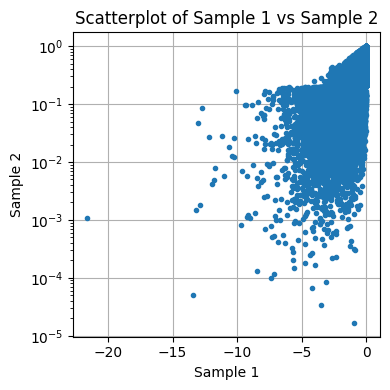

In [59]:
# Create scatterplot
plt.figure(figsize=(4, 4))
plt.semilogy(scores["lira"], scores["rmia"], '.')
plt.xlabel("Sample 1")
plt.ylabel("Sample 2")
plt.title("Scatterplot of Sample 1 vs Sample 2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [110]:
scores

{'lira': array([-0.00357912, -1.09904318, -0.41657026, ..., -1.26199052,
        -0.56127684, -0.86225664], shape=(60000,)),
 'rmia': array([0.76100004, 0.35153332, 0.60075   , ..., 0.46926668, 0.6506    ,
        0.32453334], shape=(60000,), dtype=float32)}

In [121]:
from scipy.stats import rankdata

scores_rank = {
    key: rankdata(score) for (key, score) in scores.items()
}

scores_rank


{'lira': array([57116., 11291., 26907., ...,  9371., 22033., 14980.],
       shape=(60000,)),
 'rmia': array([45661. , 21093. , 36046. , ..., 28157. , 39037. , 19473.5],
       shape=(60000,))}

In [122]:
curves_rank = { 
    key: roc_curve(target_inmask[~np.isnan(scores_rank[key]),0], scores_rank[key][~np.isnan(scores_rank[key])]) for key in scores_rank.keys()
}
curves_rank["lira"]

(array([0.        , 0.        , 0.        , ..., 0.99993333, 0.99993333,
        1.        ], shape=(26023,)),
 array([0.00000000e+00, 3.33333333e-05, 2.16666667e-03, ...,
        9.99966667e-01, 1.00000000e+00, 1.00000000e+00], shape=(26023,)),
 array([       inf, 6.0000e+04, 5.9936e+04, ..., 4.0000e+00, 3.0000e+00,
        1.0000e+00], shape=(26023,)))

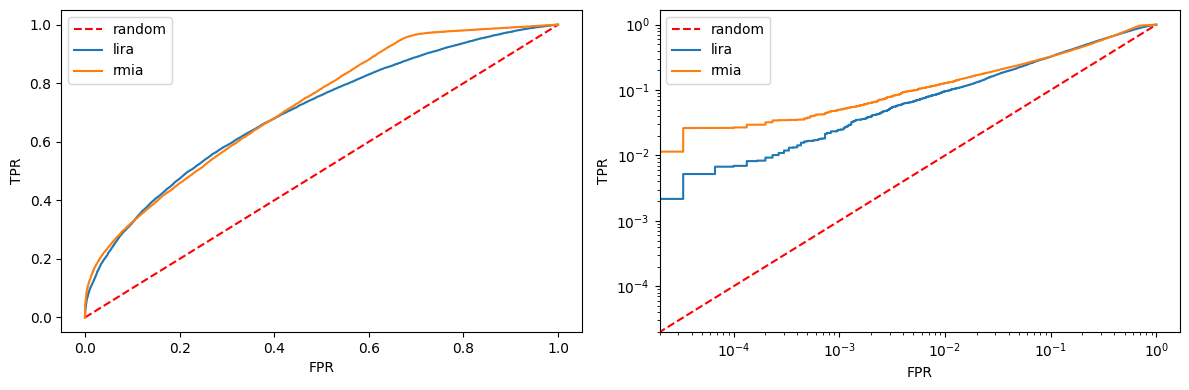

In [123]:
fpr00 = curves_rank["lira"][0]

fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(fpr00, fpr00, 'r--', label="random")
axs[1].loglog(fpr00, fpr00, 'r--', label="random")
for i in [0,1]:
    for (key,(fpr, tpr, _)) in curves_rank.items():
        axs[i].plot(fpr, tpr, label=key)
    axs[i].set_xlabel("FPR")
    axs[i].set_ylabel("TPR")
    axs[i].legend()
plt.tight_layout()
plt.show()


In [184]:
#rt = np.arange(101)*600
rt = np.arange(601)*100

b1 = scores_rank["lira"].reshape(-1,1,1) > rt.reshape(1,-1,1)  
b2 = scores_rank["rmia"].reshape(-1,1,1) > rt.reshape(1,1,-1)
b1.shape, b2.shape, np.isnan(b1).any(), np.isnan(b2).any()


((60000, 601, 1), (60000, 1, 601), np.False_, np.False_)

In [185]:
tpr_union = np.ravel(np.sum(target_inmask.reshape(-1,1,1) & (b1 & b2), axis=0) / target_inmask.sum())
fpr_union = np.ravel(np.sum(~target_inmask.reshape(-1,1,1) & (b1 & b2), axis=0) / np.sum(~target_inmask))


In [186]:
tpr_inter = np.ravel(np.sum(target_inmask.reshape(-1,1,1) & (b1 | b2), axis=0) / target_inmask.sum())
fpr_inter = np.ravel(np.sum(~target_inmask.reshape(-1,1,1) & (b1 | b2), axis=0) / np.sum(~target_inmask))


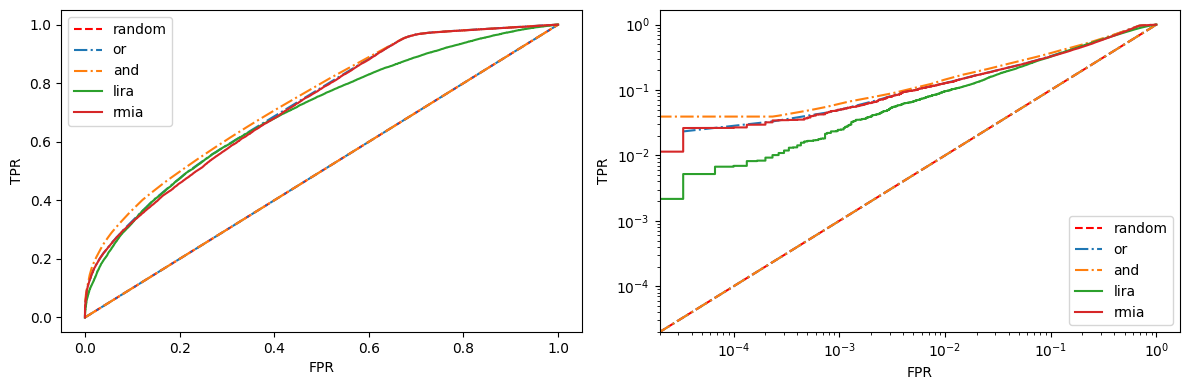

In [188]:
from scipy.spatial import ConvexHull

def pareto(fpr, tpr):
    points = np.column_stack((fpr, tpr))
    hull = ConvexHull(points)
    # hull.vertices gives indices of convex hull points
    pareto_points = points[hull.vertices]
    return pareto_points[:,0], pareto_points[:,1]

fpr00 = curves_rank["lira"][0]

fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(fpr00, fpr00, 'r--', label="random")
axs[1].loglog(fpr00, fpr00, 'r--', label="random")
for i in [0,1]:
    axs[i].plot(*pareto(fpr_inter,tpr_inter), '-.', label="or")
    axs[i].plot(*pareto(fpr_union,tpr_union), '-.', label="and")
    for (key,(fpr, tpr, _)) in curves_rank.items():
        axs[i].plot(fpr, tpr, label=key)
    axs[i].set_xlabel("FPR")
    axs[i].set_ylabel("TPR")
    axs[i].legend()
plt.tight_layout()
plt.show()
